In [1]:
%matplotlib inline
import openmc

In [2]:
#create materials

#fuel
Am = openmc.Material(1, "Am242m")
Am.add_nuclide('Am242_m1',1)
Am.set_density('g/cm3',13.6)
print(Am)

#moderator
BeO = openmc.Material(2, "BeO")
BeO.add_nuclide("Be9", .5)
BeO.add_nuclide("O16", .5)
BeO.set_density("g/cm3", 2.86)
print(BeO)

Material
	ID             =	1
	Name           =	Am242m
	Temperature    =	None
	Density        =	13.6 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Am242_m1       =	1            [ao]

Material
	ID             =	2
	Name           =	BeO
	Temperature    =	None
	Density        =	2.86 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	0.5          [ao]
	O16            =	0.5          [ao]



In [3]:
#create materials & cross sections xmls
mats = openmc.Materials()
mats.cross_sections = '/home/james/nndc_hdf5/cross_sections.xml' #comment this out/replace if you need to
mats.append(Am)
mats += [BeO]

#export materials
mats.export_to_xml()

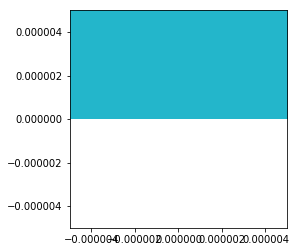

In [4]:
#create 1D slab model

fuel_width = .002 # .2 microns
moder_width = 5 #cm

#boundaries for the simulation
z_0=openmc.ZPlane(z0=0, boundary_type="reflective")
z_f=openmc.ZPlane(z0=fuel_width)
z_m=openmc.ZPlane(z0=fuel_width+moder_width, boundary_type="vacuum")

fuel_region= +z_0 & -z_f
moderator_region= +z_f & -z_m
vacuum_region= +z_m & -z_0

#fill fuel region
fuel=openmc.Cell(1,'fuel')
fuel.fill=Am
fuel.region=fuel_region

#fill moderator region
moderator=openmc.Cell(2,'moderator')
moderator.fill=BeO
moderator.region=moderator_region

#fill vacuum region
vacuum=openmc.Cell(3,'vacuum')
vacuum.region=vacuum_region

#visualize moderator fuel boundary
universe = openmc.Universe(cells=[vacuum, fuel, moderator])
universe.plot(width=(0.00001, 0.00001), basis='xz')

In [5]:
#create root universe
root = openmc.Universe(cells=(fuel, vacuum, moderator))
geom = openmc.Geometry()
geom.root_universe = root

#configure statistics geometry
source = openmc.stats.Box((0, 0, 0), (0, 0, fuel_width), only_fissionable=True)
#source = openmc.stats.Point((0, 0, fuel_width/2))
src = openmc.Source(space=source)

#export geometry
geom.export_to_xml()

In [6]:
#more settings
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

#export settings
settings.export_to_xml()

In [7]:
#configure tallies
cell_filter = openmc.CellFilter(fuel)
t = openmc.Tally(3)
t.filters = [cell_filter]
t.scores = ['fission']
tallies = openmc.Tallies([t])

#export tallies
tallies.export_to_xml()

In [8]:
# run it
openmc.run()

openmc: Relink `/home/james/anaconda3/bin/../lib/./libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               ####################

1

In [9]:
#check the tallies
!cat tallies.out


 ============================>     TALLY 1     <============================

 Cell 1
   Am242_m1
     Total Reaction Rate                  1.11889        +/- 2.84113E-03
     Fission Rate                         0.285530       +/- 7.34006E-04
     Absorption Rate                      0.300425       +/- 7.95715E-04
     (n,gamma)                            1.50616E-02    +/- 8.50713E-05

 ============================>     TALLY 2     <============================

 Cell 1
   Total Material
     Flux                                 4.65008        +/- 1.12553E-02
